In [1]:
%matplotlib inline

# misc. libraries
import pandas as pd
import numpy as np

# plotting libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# ml libraries
from sklearn.decomposition import PCA

%load_ext autoreload
%autoreload 2

In [2]:
# local dependencies
from load import *
from helpers import *
from plots import *
from constants import *

***
**Data loading and manipulation**
***

*Load data about differentially expressed genes in the PDX experiment*

In [3]:
%pycat constants

"""Constants"""

# misc/general
UP_DOWN = ["up", "down"]

CTRL = "ctrl"
HORMONES = ["dht", "e2", "p4"]
HORMONES_CTRL = HORMONES + [CTRL]
TUMORS = ["t111", "t110", "pl015"]

LABELS = dict(zip(HORMONES, list(range(3))))
LABELS_CTRL = dict(zip(HORMONES_CTRL, list(range(4))))

LABELS_INVERTED = dict(map(reversed, LABELS.items()))
LABELS_CTRL_INVERTED = dict(map(reversed, LABELS_CTRL.items()))

CORR_THRESHOLD = .6

# clustering
NUM_CLUSTERS = range(2, 7)
CLUSTERING_METHODS = ["agglomerative", "kmeans", "spectral"]
CLUSTERING_METRICS = ["ari", "silhouette", "db"]
AFFINITIES = ["euclidean", "l1", "l2", "manhattan", "cosine"]
LINKAGES = ["ward", "average", "complete", "single"]

# paths
DATA_DIR = "../data"
PLOT_DIR = "../results/plots"
PKL_DIR = DATA_DIR + "/pickle"

GENES_PATH = f"{DATA_DIR}/pdx/List of Genes Differentially Expressed upon Different Treatments.xlsx"
PDX_PATH = f"{DATA_DIR}/pdx/Human_matrix_DESEQ2normalized_removedlowlyexpressedgenes.xlsx"
PATIENTS_PATH = f"{DATA_DIR}/patients

In [4]:
%psource load_genes

def load_genes():
    """Load raw information about the genes"""
    pkl = f"{PKL_DIR}/genes_raw.pkl"
    try:
        return pd.read_pickle(pkl)
    
    except:
        columns = [(i, j) for i in HORMONES for j in UP_DOWN]
        multi_index = pd.MultiIndex.from_tuples(columns)

        genes = pd.read_excel(
            GENES_PATH,
            names=multi_index,
            skiprows=[0, 1],
            usecols=[1, 2, 4, 5, 7, 8],
        )
        genes.to_pickle(pkl)
        return genes


In [5]:
# Raw information about genes
genes = load_genes()
genes

dht                 e2                      p4          
          up      down       up        down          up      down
0       KLK3      CPB1      NTS        CPB1        KLK3     RAB31
1       GPC3    CITED1      DCX  AC062028.2      CXCL13       PGR
2      GPR88     GRIK3  COL22A1      SPINK4        DIO2  FLNB-AS1
3    UGT2B11      LYG1    IGSF1       POTEJ         TAT     ZNF71
4       KLK2     DCDC2   NECAB1         ALB     ADAMTS8    ZNF282
5    UGT2B28   ZNRF2P1   PIEZO2       MS4A7      MYBPC1    QRICH1
6    SLC26A3      CISH     TP63      PLA2G3     UGT2B11       NaN
7   TMEM176A    ZNF107  TMPRSS4     CACNA1H       NTRK3       NaN
8       HPGD       GHR    KLK12    CYP4F30P        DLC1       NaN
9     CYP4F8    NFKBIE     HPGD      MS4A14      ABCA13       NaN
10     DHRS2   FAM217B    KLK14    CYP4F29P      GIMAP6       NaN
11    ATP1A2     GFOD1  SCGB3A1      KLF2P3     SLC26A3       NaN
12    TSPAN8     RIPK2    KCNK3       PEX5L       PDE2A       NaN
13   ALOX15B   TNFAIP3    NTRK3       TPSG1     SPARCL1       NaN
14   HSD17B2  TMEM106B     NEFH       NELL2      SYNPO2       NaN
15    COL3A1    FAM92A    GRIK4      FAR2P3       LAMA1       NaN
16   RANBP3L     BICD1    OLFM4    CYP4F62P      CLEC7A       NaN
17      SOX2      FGD6    RFLNA      CRTAC1  AL591034.3       NaN
18    MYBPC1    FAM83B   RUBCNL      SORCS1      ZBTB16       NaN
19    CXCL13   PLEKHO1    GREB1   SOCS2-AS1     ADAMTS1       NaN
20     FGFR4   MAP3K14  SLC34A2     BPIFA4P      PKD1L1       NaN
21   COL12A1      PER2     SDC2        CSTA       CYYR1       NaN

In [6]:
%psource load_genes_list

def load_genes_list():
    """Load the preprocessed list of genes"""
    pkl = f"{PKL_DIR}/genes_list.pkl"
    try:
        return pd.read_pickle(pkl)
    
    except:
        genes_list = pd.read_excel(GENES_PATH, sheet_name=1)
        genes_list.columns = genes_list.columns.str.lower()
        genes_list.to_pickle(pkl)
        return genes_list


In [7]:
# Preprocessed list of genes
genes_list = load_genes_list()
genes_list.head()

,genes,dht,e2,p4,upregulated
0,ABCA13,False,False,True,True
1,AC062028.2,False,True,False,False
2,ADAMTS1,False,False,True,True
3,ADAMTS8,False,False,True,True
4,AL591034.3,False,False,True,True


Some of the genes show response to two hormones:

In [8]:
genes_list[genes_list[HORMONES].sum(axis=1) == 2]

,genes,dht,e2,p4,upregulated
17,CPB1,True,True,False,False
20,CXCL13,True,False,True,True
46,HPGD,True,True,False,True
54,KLK3,True,False,True,True
60,MYBPC1,True,False,True,True
65,NTRK3,False,True,True,True
85,SLC26A3,True,False,True,True
101,UGT2B11,True,False,True,True


*Load genetic expression levels from the patient derived xenograft (PDX) experiment on mice*

In [9]:
%psource load_pdx

def load_pdx():
    """Load PDX tumor data, only retaining certain genes"""
    pkl = f"{PKL_DIR}/pdx.pkl"
    try:
        return pd.read_pickle(pkl)
    
    except:
        genes = load_genes_list().genes
        patients = load_patients()
        
        pdx = pd.read_excel(
            PDX_PATH,
            index_col=0,
            usecols=[1] + list(range(4, 46)),
        ).T

        # Not all the genes are expressed in every cell
        # and within a broad set of samples, so we discard
        # genes not expressed in the patients datasets
        pdx = pdx.loc[:, pdx.columns.isin(genes) & pdx.columns.isin(patients.columns)]
        
        # Remove subjects exposed to two treatments
        pdx = pdx[~pdx.index.str.contains(r"\+")]
        
        # Transform the index into a multi-index
        # First level:  treatments (dht, e2, p4, ctrl)
        # Second level: tumor (t110, t111, pl015)
        # Third level: subject id
        index_split = pdx.index.str.lower().str.

In [10]:
pdx = load_pdx()
pdx.head()

label    ABCA13   ADAMTS1   ADAMTS8       ALB  \
treatment tumor id                                                      
ctrl      pl015 g3_m31      3  5.868254  6.578944  3.189617  6.178456   
                g3_m36      3  7.061650  6.456036  3.453102  6.450958   
                g3_m40      3  7.517644  6.828822  3.572844  6.556117   
          t110  g2_m01      3  4.546672  7.605361  3.189617  6.704684   
                g2_m02      3  4.606720  7.594579  3.189617  6.933231   

                         ALOX15B    ATP1A2     BICD1   CACNA1H      CISH  ...  \
treatment tumor id                                                        ...   
ctrl      pl015 g3_m31  4.037543  3.189617  9.921005  3.550028  4.304365  ...   
                g3_m36  3.830632  3.561727  9.029374  3.881065  4.622554  ...   
                g3_m40  3.994478  3.792929  9.632278  3.792929  4.252532  ...   
          t110  g2_m01  3.189617  6.187382  7.002553  3.830212  3.511882  ...   
                g2_m02  3.416943  6.014096  7.330597  3.189617  3.510773  ...   

                         TNFAIP3      TP63     TPSG1    TSPAN8    UGT2B11  \
treatment tumor id                                                          
ctrl      pl015 g3_m31  5.135406  4.249658  8.501410  8.560964  10.189669   
                g3_m36  4.622554  4.051824  8.549851  7.912770   9.605342   
                g3_m40  4.874413  3.994478  9.561085  7.969911  10.453979   
          t110  g2_m01  3.511882  3.644430  8.953595  8.896594   7.111983   
                g2_m02  3.510773  3.416943  8.713664  8.768786   6.855711   

                         UGT2B28    ZBTB16    ZNF107    ZNF282     ZNF71  
treatment tumor id                                                        
ctrl      pl015 g3_m31  5.848797  8.774109  4.864249  3.398061  4.683222  
                g3_m36  5.648358  8.763580  4.558562  3.189617  4.466761  
                g3_m40  6.198741  8.825129  4.399317  3.189617  3.849570  
          t110  g2_m01  6.598892  9.575205  4.032005  3.830212  3.189617  
                g2_m02  6.818234  9.488212  3.642873  3.828035  3.189617  

[5 rows x 92 columns]

**Note** that `ctrl` means that the subject is a control subject, i.e. it was not treated with a hormone. Also, `pl015` is a metastasis tumor whereas `t110` and `t111` are types of primary site tumors.

Let's now standardize the features per tumor (to eliminate bias introduced by different tumors being injected):

In [11]:
%psource df_standardize_cols

def df_standardize_cols(df):
    """Standardize dataframe columns"""
    return (df-df.mean(axis=0)) / df.std(axis=0)


In [12]:
%psource pdx_standardize

def pdx_standardize(X_pdx):
    """Standardize the PDX feature matrix per tumor and return the concatenated dataframe,
     the aim being to eliminate bias introduced by different tumors being injected"""
    dfs_stdized = []
    for tumor in TUMORS:
        df = X_pdx.xs(tumor, level=1, drop_level=False)
        df_stdized = df_standardize_cols(df)
        dfs_stdized.append(df_stdized)
    
    return pd.concat(dfs_stdized).sort_values(["treatment", "tumor"])


In [13]:
# Separate features from the label
X_pdx = pdx.drop(columns="label")
y_pdx = pdx["label"]

X_pdx_stdized = pdx_standardize(X_pdx)

*Load genetic expression levels of tumor patients*

In [14]:
%psource load_patients

def load_patients():
    """Load first patient dataset, only retaining certain genes"""
    pkl = f"{PKL_DIR}/patients.pkl"
    try:
        return pd.read_pickle(pkl)
    
    except:
        genes = load_genes_list().genes
        
        patients = pd.read_excel(
            PATIENTS_PATH,
            index_col=0,  # first column contains genes
        ).T
        
        # replace indexing of patients with RangeIndex
        patients.reset_index(drop=True, inplace=True)
        
        # keep only selected genes
        patients = patients.loc[:, patients.columns.isin(genes)]
        
        patients.to_pickle(pkl)
        return patients


In [15]:
%psource load_patients2

def load_patients2():
    """Load second patient dataset, only retaining certain genes"""
    pkl = f"{PKL_DIR}/patients2.pkl"
    try:
        return pd.read_pickle(pkl)
    
    except:
        genes = load_genes_list().genes
        
        patients = pd.read_csv(
            PATIENTS_PATH_2,
            sep="\t",
            index_col=0,  # first column contains genes
            skiprows=1,
        ).T

        # Replace indexing of patients with RangeIndex
        patients.reset_index(drop=True, inplace=True)

        # Remove number identifiers that follow the gene name
        patients.columns = patients.columns.str.split("|").map(lambda x: x[0])

        # Remove the default name
        patients.columns.set_names(None, inplace=True)
        
        # Keep only selected genes
        patients = patients.loc[:, patients.columns.isin(genes)]
        
        patients.to_pickle(pkl)
        return patients


In [16]:
# Load TCGA first tumor-patients dataset
patients = load_patients()
print(f"There are {len(patients)} records in the first dataframe")

There are 617 records in the first dataframe


In [17]:
# Load TCGA second tumor-patients dataset
patients2 = load_patients2()
print(f"There are {len(patients2)} records in the second dataframe")

There are 1212 records in the second dataframe


***
**Exploratory data analysis**
***

We don't know beforehand if it is okay to merge the two patient datasets. They have the same 91 features but we don't know their distributions or how they were normalized. Let's investigate the distribution of features for both datasets in order to evaluate the feasibility of merging the two sets:

In [18]:
# Discard highly expressed genes to make the plot readable
highly_expressed_genes = ["COL12A1", "COL3A1", "CPB1"]

pat = patients.drop(columns=highly_expressed_genes)
pat2 = patients2.drop(columns=highly_expressed_genes)

pat_mean_std = {"mean": pat.mean(), "std": pat.std()}
pat2_mean_std = {"mean": pat2.mean(), "std": pat2.std()}

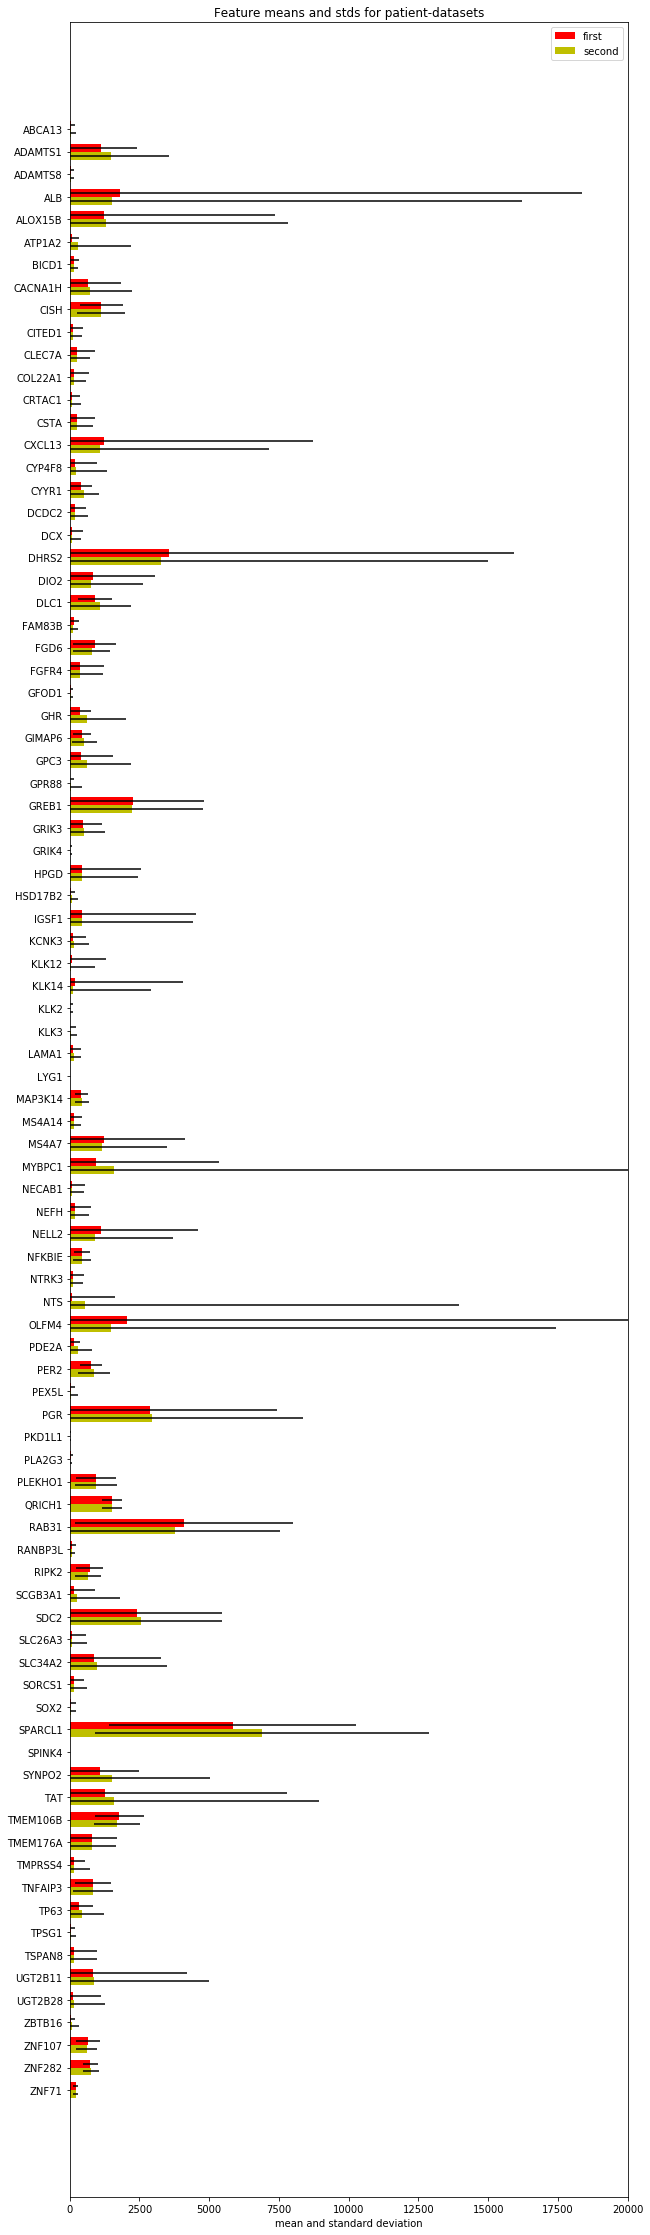

In [19]:
plot_means_std_patients(pat_mean_std, pat2_mean_std)

Let's also compare the highly expressed genes: 

In [20]:
pat_high = patients[highly_expressed_genes]
pat2_high = patients2[highly_expressed_genes]

pd.DataFrame(
    [pat_high.mean(), pat2_high.mean(), pat_high.std(), pat2_high.std()],
    index=pd.MultiIndex.from_tuples(
        [(i, j) for i in ["mean", "std"] for j in ["first", "second"]]
    ),
)

COL12A1        COL3A1           CPB1
mean first   12999.915276  98042.952695   29147.933945
     second  11669.320812  90704.301240   32574.941953
std  first   11876.024778  89098.300863  148764.333882
     second  11404.544276  93349.498611  165193.839563

We observe that the standard deviations of features are quite high, which indicates that the values are spread out over a wide range. Genetic expression levels in tumor patients don't appear to follow normal distributions, rather quite heavy-tailed distributions. We note that some features, like `MYBPC1` and `NTR`, have much greater variance in the second dataset. This can perhaps be explained by the fact that the second dataset has more datapoints, so the number of outliers will generally be higher which results in a higher standard deviation.

To conclude with the analysis of the above plot, we generally see that each feature seems to have a similar distribution in the two datasets. Based on this information we reason it is safe to merge the two sets. Let's call the new dataframe `pats`:

In [21]:
pats = pd.concat([patients, patients2]).reset_index(drop=True)

In [22]:
num_duplicates = pats.duplicated(keep=False).sum()
print(f"There are {len(pats)} records in the merged dataframe")
print(f"There are {num_duplicates} duplicated records in the merged dataframe")

There are 1829 records in the merged dataframe
There are 208 duplicated records in the merged dataframe


Interestingly, the two datasets have 104 entries in common! Presumably, these are 104 unique tumor patients.

However, we haven't discovered all duplicated records, since there are some *fuzzy* duplicates which contain floating point precision errors in one dataset and not the other. Here is one example:

In [23]:
pats_fuzzy_duplicate_example = pats.loc[[197, 1134], :]
fuzzy_genes = ["TPSG1", "MAP3K14"]
for g in fuzzy_genes:
    print(f"{g}: {list(pats_fuzzy_duplicate_example[g].values)}")

TPSG1: [2.5789999999999997, 2.579]
MAP3K14: [89.94200000000001, 89.942]


We will fix this by rounding all values to 4 decimal places and see how many duplicates there are in total:

In [24]:
pats = round(pats, 4)

In [25]:
pats.duplicated(keep=False).sum()

1234

Seems like there are 617 entries in common between the two datasets. But wait a minute... that's exactly the number of entries in the first dataset! Let's see if the second dataset contains the entire first dataset:

In [26]:
duplicates = pd.concat([pats[pats.duplicated()], round(patients, 4)]).reset_index(drop=True)
duplicates.duplicated(keep=False).sum()

1234

When concatenating the duplicated entries in the merged dataframe and entries in the first dataframe, once again we get 617 entries in common.

Let's drop duplicated entries:

In [27]:
pats = pats.drop_duplicates().reset_index(drop=True)
print(f"Now, we have {len(pats)} unique records in the merged dataframe")

Now, we have 1212 unique records in the merged dataframe


Finally, we verify that no expression values are negative or `NaN`:

In [28]:
pats[pats < 0 | pats.isna()].any(None)

False

***
The below boxplots further confirm the heavy-tailed nature of the feature distributions in the `pats` dataset:

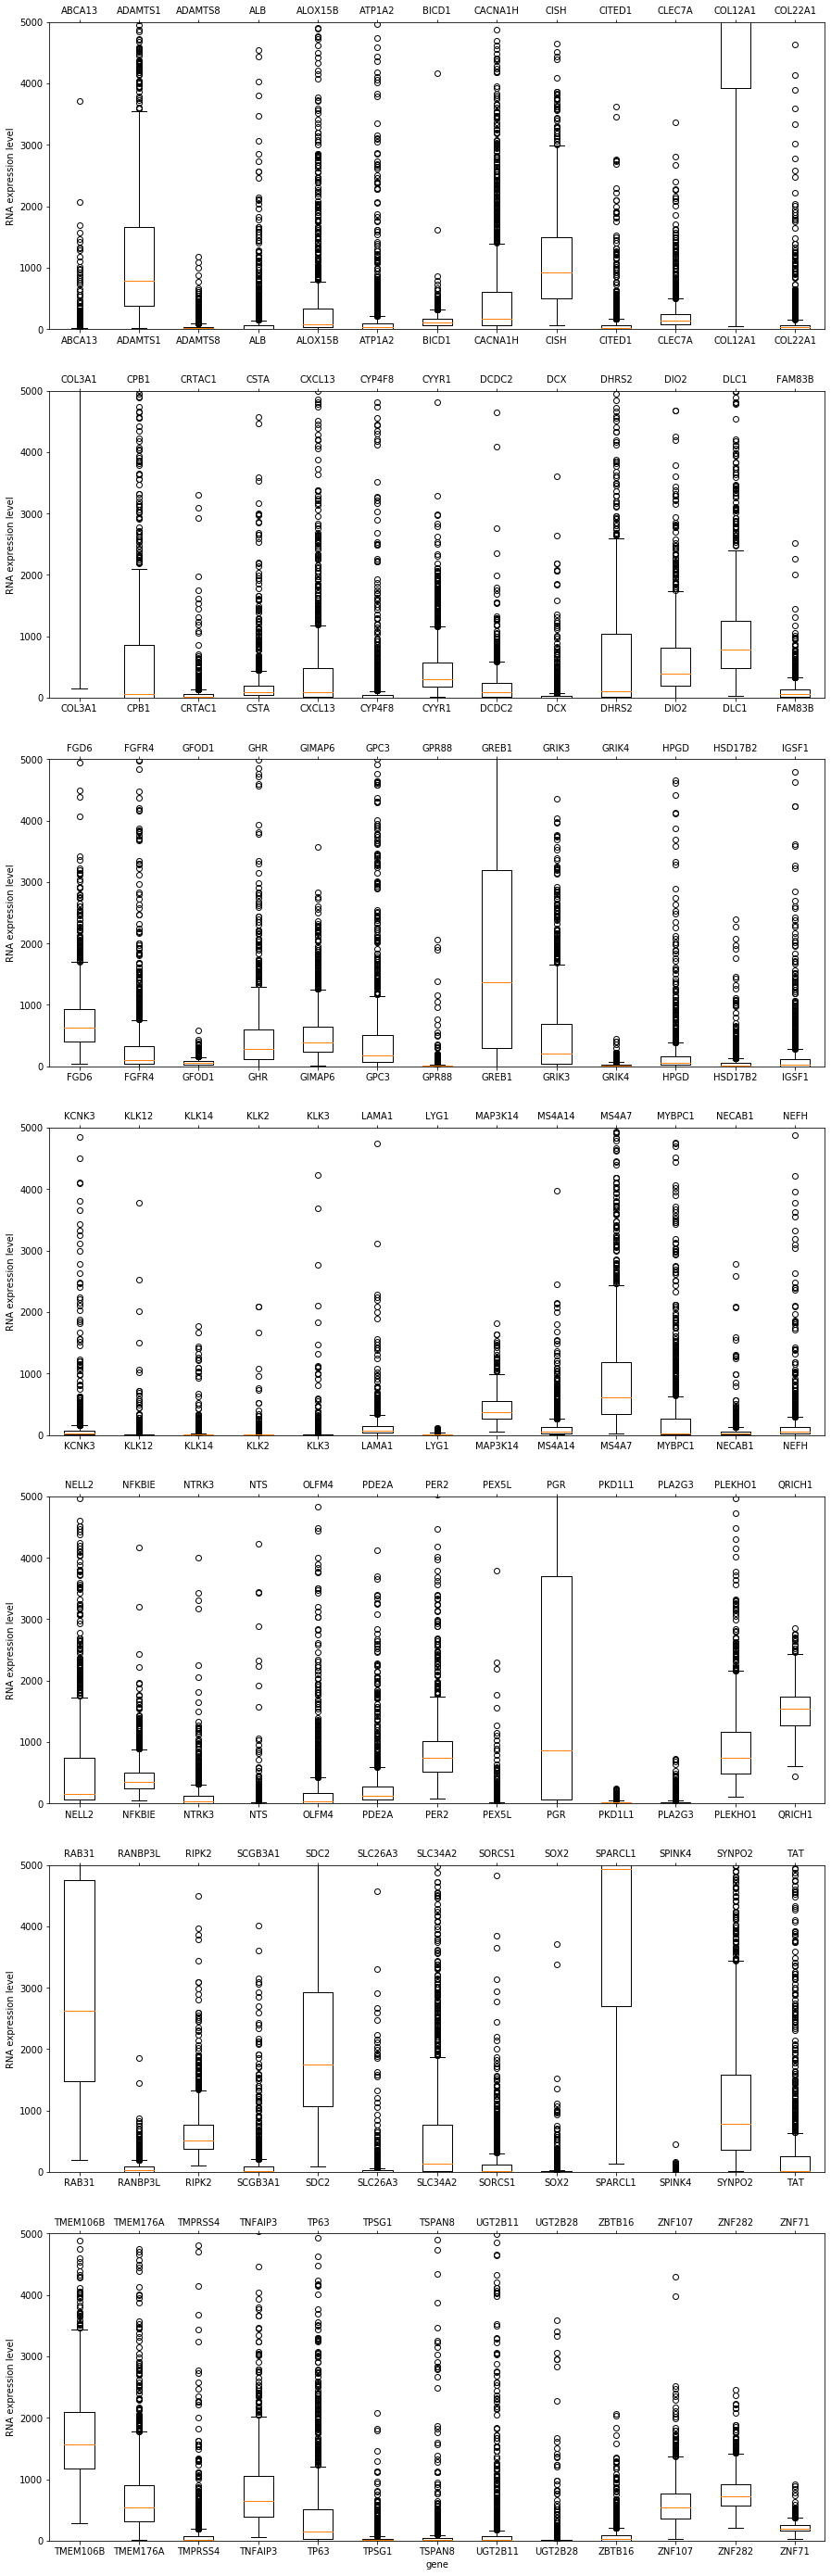

In [29]:
plot_feature_distributions(pats)

We will take the log of all features and standardize them to make the optimization behave better, since they appear to follow log-normal heavy-tailed distributions:

In [30]:
%psource df_log_standardize_cols

def df_log_standardize_cols(df):
    """Log-transform values and standardize dataframe columns"""
    # add a small constant because log(0) is undefined
    df = np.log(df + .1)
    return df_standardize_cols(df)


In [31]:
pats_log_stdized = df_log_standardize_cols(pats)

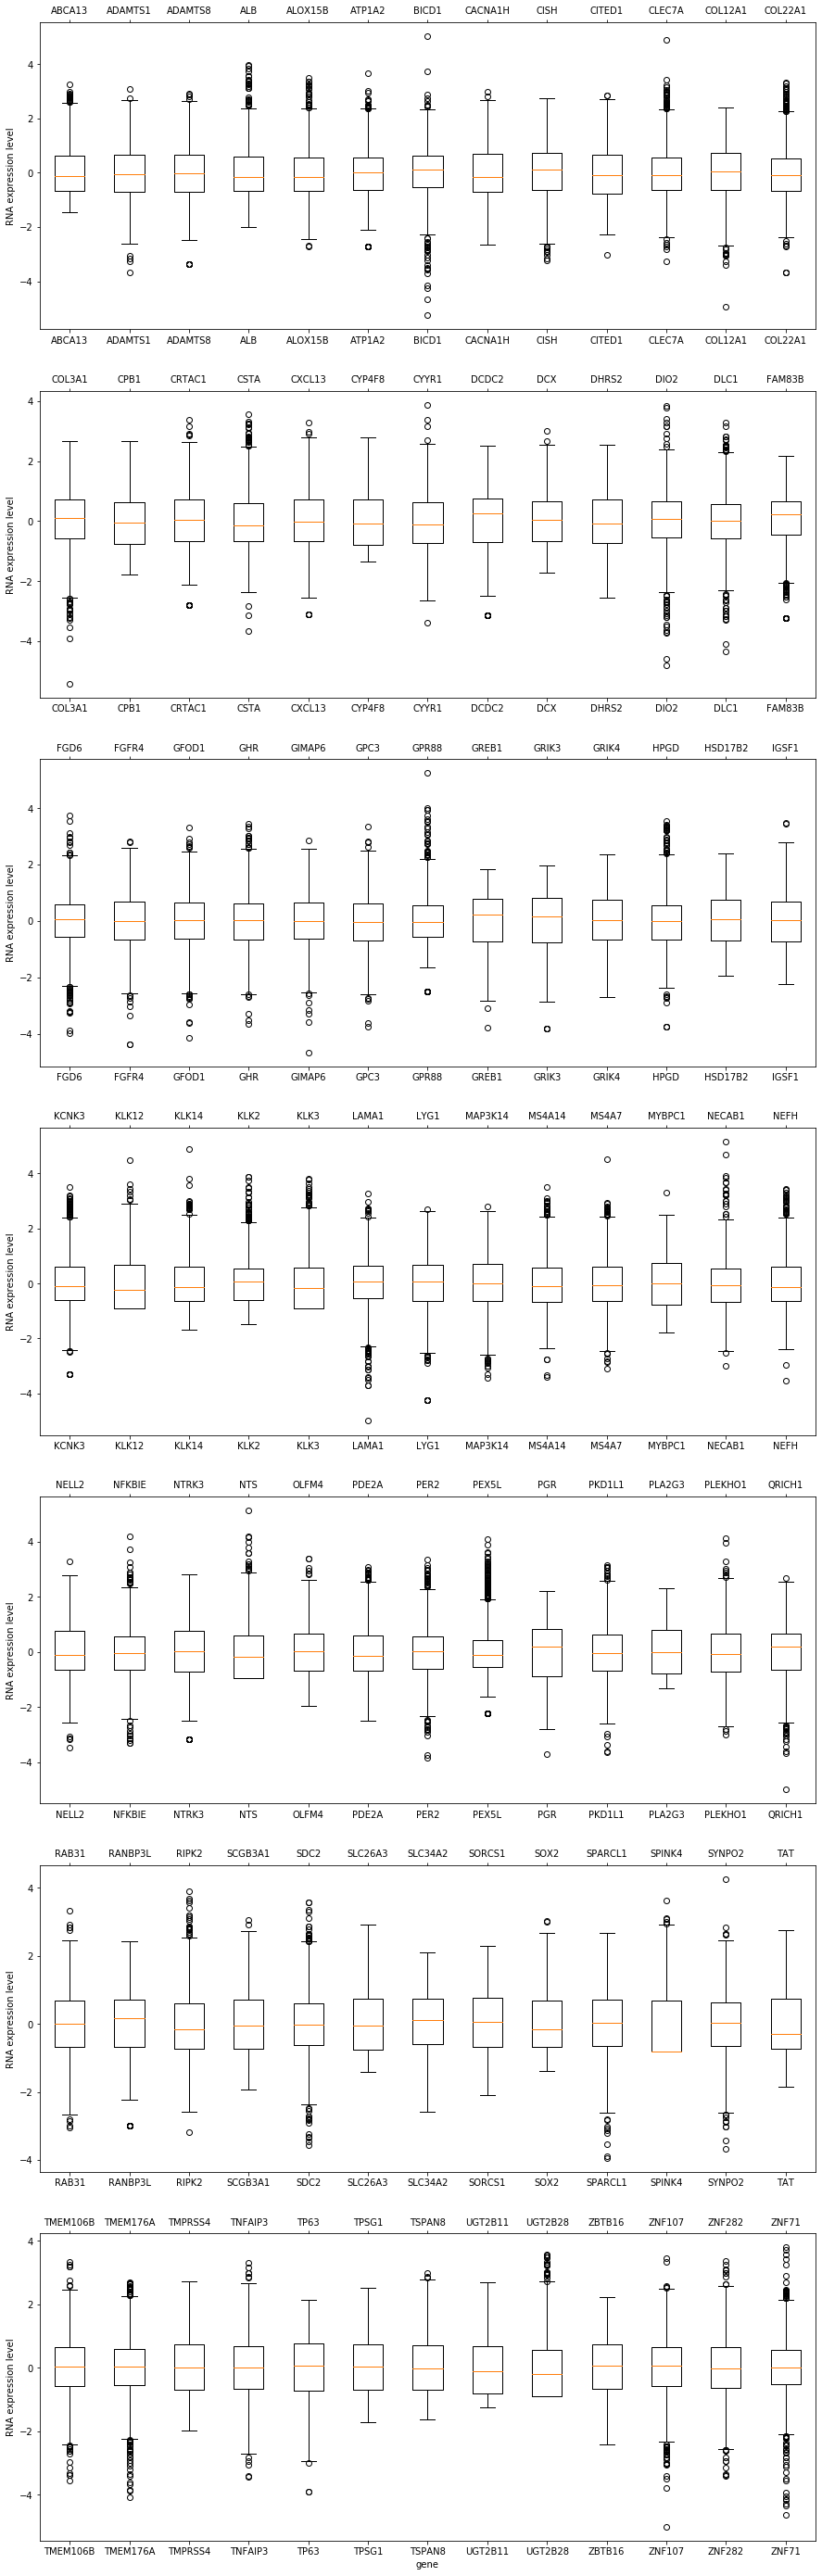

In [32]:
plot_feature_distributions(pats_log_stdized, ylim=None, filename="pats_log_stdized_distribution")

***
Not all of the genes that were strongly expressed in the PDX experiment did also show strong expression within a broad sample of tumor patients. This is what is to be expected, especially when taking into account that we are comparing data on human patients with data from a xenograft experiment. This is why the loading function of the patient dataset only keeps genes in common with the PDX dataset.

In [33]:
genes_expressed = patients.columns
genes_not_found = genes_list.genes[~genes_list.genes.isin(genes_expressed)]

In [34]:
print(f"Total number of differentially expressed genes:    {len(genes_list.genes)}")
print(f"Number of which found in the patients dataset:     {len(genes_expressed)}")
print(f"Number of which not found in the patients dataset: {len(genes_not_found)}")

Total number of differentially expressed genes:    108
Number of which found in the patients dataset:     91
Number of which not found in the patients dataset: 17


***
Let's investigate the correlation between features in the pdx and patients datasets. We shall plot a heatmap to visualize the lower triangular Pearson correlation matrix.

In [35]:
%psource df_to_tril

def df_to_tril(df):
    """Return a lower triangular dataframe where entries
    above and including the main diagonal are set to zero."""
    for index, row in df.iterrows():
        row[index <= row.index] = 0
    return df


In [36]:
pdx_corr = df_to_tril(pdx.drop("label", axis=1).corr())

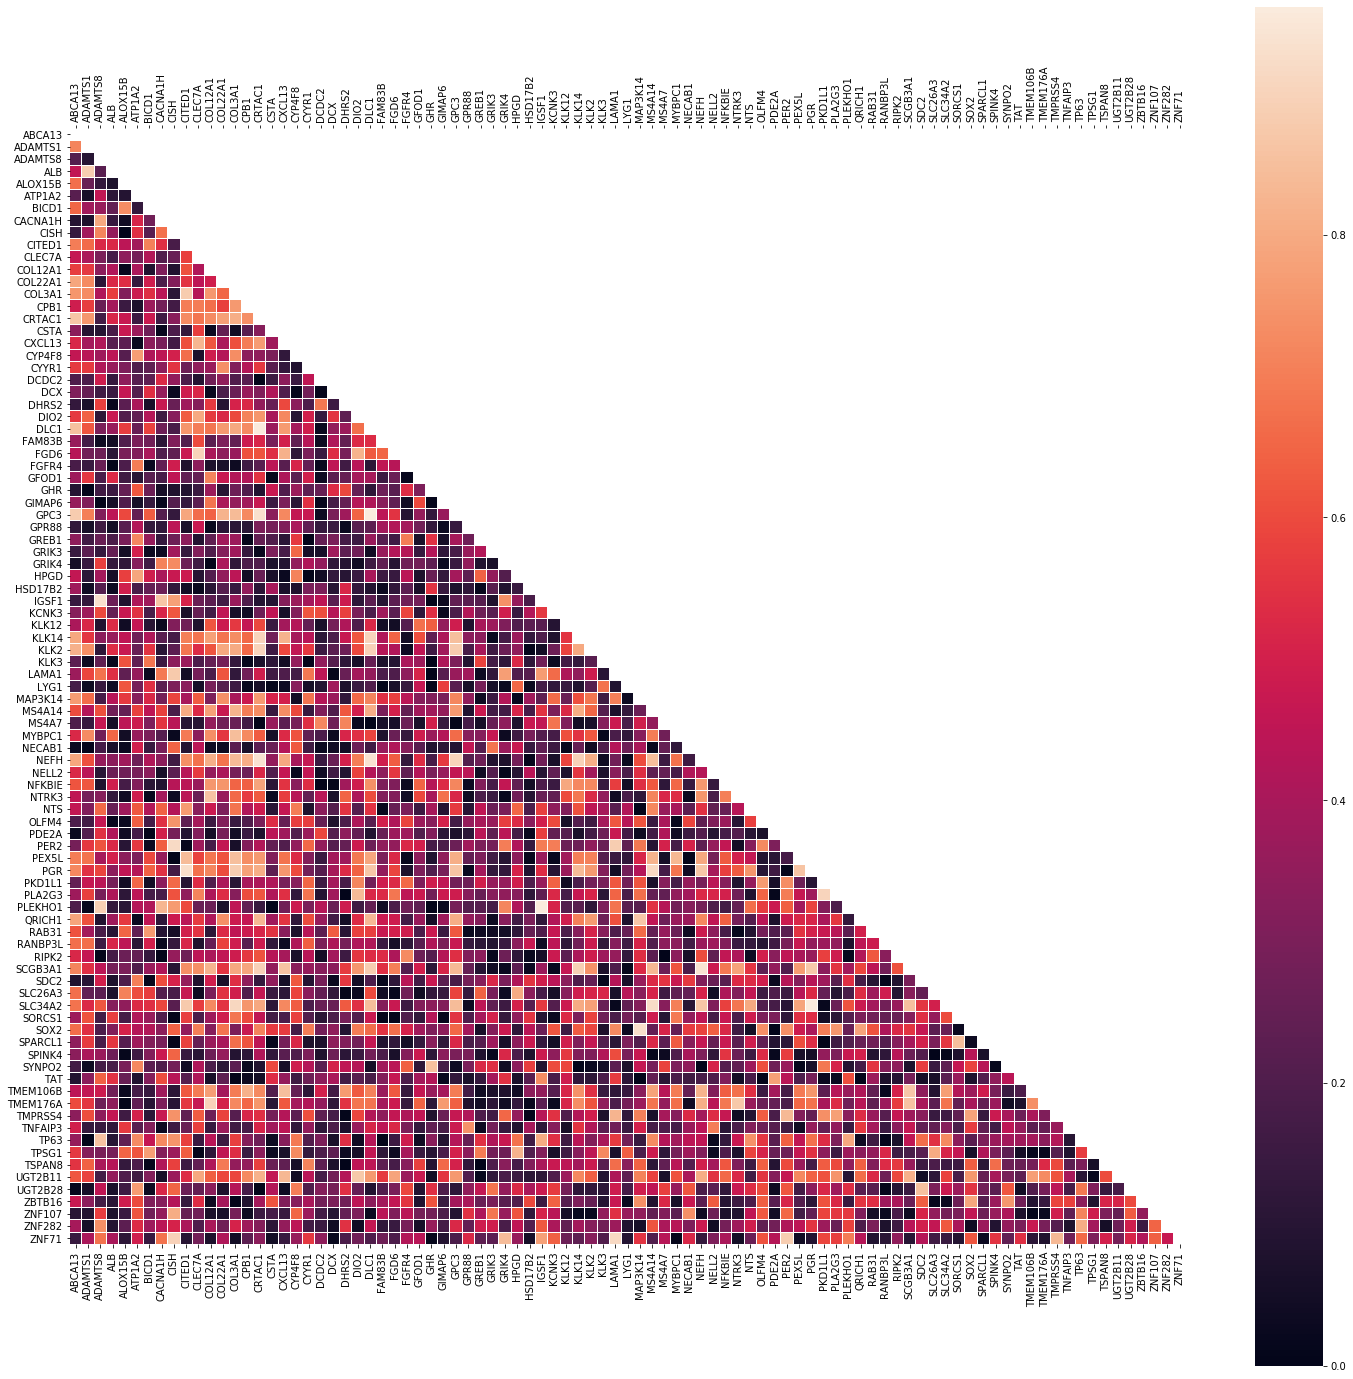

In [37]:
plot_corr(pdx_corr, genes_expressed, "corr_pdx")

In [38]:
pats_corr = df_to_tril(pats.corr())

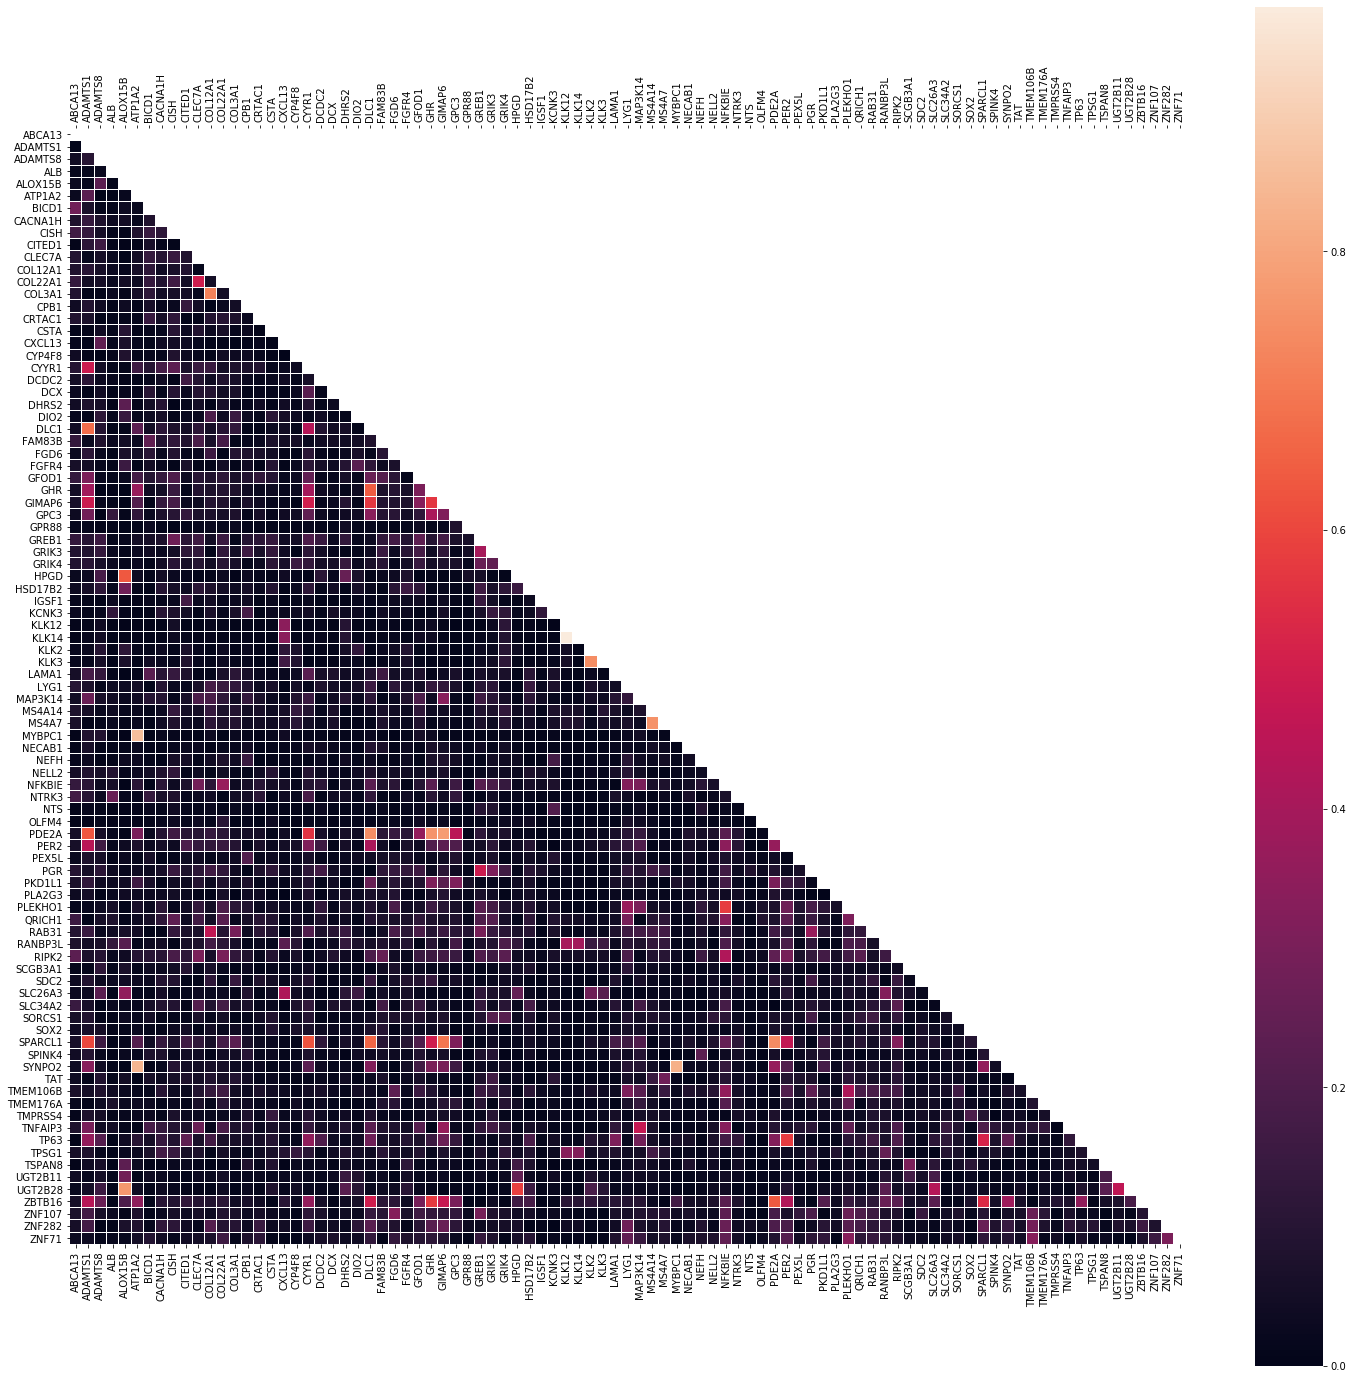

In [39]:
plot_corr(pats_corr, genes_expressed, "corr_patients")

We observe that most of the genes in the patient set are relatively uncorrelated.

It is interesting to see which pairs of genes are highly correlated. We define the reference value for "high correlation" to be...

In [40]:
CORR_THRESHOLD

0.6

We find all pairs of genes differentially expressed upon the same treatment:

In [41]:
%psource gene_pairs_per_treatment

def gene_pairs_per_treatment():
    """Return all pairs of genes differentially expressed
    upon the same treatment as a Series object with the index
    being the pair and the value being the list of treatments"""
    genes_list = load_genes_list()
    series = []

    for h in HORMONES:
        # get all genes expressing hormone h
        genes_h = genes_list[genes_list[h]]
        glist = list(genes_h.genes)

        num_genes = len(glist)

        # Compute pairs of indices for the lower triangular part of a matrix
        # of size (num_genes x num_genes), excluding the diagonal
        # (we don't want to pair the genes to themselves)
        tril_indices = np.tril_indices(num_genes, k=-1)
        index_pairs = list(zip(tril_indices[0], tril_indices[1]))

        # Map the list of index-pairs to all possible pairs of genes
        pairs = [(glist[pair[0]], glist[pair[1]]) for pair in index_pairs]

        # Create the series and append to list
        series_h = pd.Series(data=

In [42]:
pdx_genes_pairs = gene_pairs_per_treatment()

Then we find the highly correlated pairs of genes in the patients dataset (by Pearson correlation):

In [43]:
# Get pairs of highly correlated genes
pats_corr_genes = pats_corr[pats_corr > CORR_THRESHOLD].stack()

# Turn the multi-index into a normal index,
# give the series a name and then sort it in a descending order
pats_corr_genes.index = pats_corr_genes.index.tolist()
pats_corr_genes.name = "correlation"
pats_corr_genes.sort_values(ascending=False, inplace=True)

In [44]:
# Merge the two sets of pairs to find pairs present in both sets
correlated_genes = pd.DataFrame(pats_corr_genes).join(pdx_genes_pairs)
correlated_genes["correlation"] = round(correlated_genes.correlation, 2)
correlated_genes

,correlation,hormone
"(KLK14, KLK12)",0.98,[e2]
"(MYBPC1, ATP1A2)",0.86,[dht]
"(SYNPO2, ATP1A2)",0.84,NaN
"(SYNPO2, MYBPC1)",0.82,[p4]
"(PDE2A, GIMAP6)",0.78,[p4]
"(UGT2B28, ALOX15B)",0.77,[dht]
"(PDE2A, GHR)",0.76,NaN
"(MS4A7, MS4A14)",0.76,[e2]
"(KLK3, KLK2)",0.75,[dht]
"(PDE2A, DLC1)",0.74,[p4]


There appear to be many correlations in the patient dataset that match the PDX data. Note that `NaN` means the two genes showed expressions from different hormone treatments in the PDX experiment, i.e. the correlation does not match the PDX results.

Does this not confirm the potentiality of transferring what has been learned in the PDX experiment to tumor patients?

In [45]:
# Print correlation table to CSV and LaTeX for the report
correlated_genes.dropna(inplace=True)
correlated_genes["hormone"] = correlated_genes.hormone.apply(lambda x: x[0])
correlated_genes.to_csv("../results/correlated_genes.csv")
correlated_genes.to_latex(open("../results/correlated_genes.tex", "w"))

***
*Visualizing patterns with PCA*

Let's visualize the PDX samples by dimensionality reduction using PCA:

**Original PDX data**

First 2 components explain 63.84% of the variance in the original data


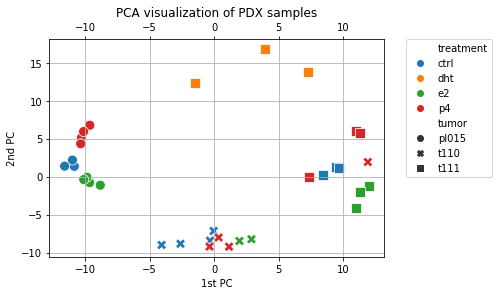

In [46]:
pca_visualize_2d(X_pdx, pdx.index, title="PCA visualization of PDX samples")

In [47]:
pca_visualize_3d(X_pdx, labels=pdx.index, filename="pdx-original-pca-3d")

First 3 components explain 72.99% of the variance in the original data


[See plot here](https://plot.ly/~valentin.loftsson/65/#/)

**Standardized PDX data**

First 2 components explain 40.72% of the variance in the original data


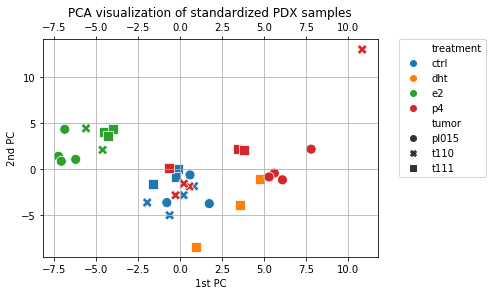

In [48]:
pca_visualize_2d(X_pdx_stdized, pdx.index, title="PCA visualization of standardized PDX samples")

In [49]:
pca_visualize_3d(X_pdx_stdized, labels=pdx.index, filename="pdx-stdized-pca-3d")

First 3 components explain 54.3% of the variance in the original data


[See plot here](https://plot.ly/~valentin.loftsson/63/#/)

***
Let's visualize the patient dataset in the same way:

**Original patient data**

First 2 components explain 95.76% of the variance in the original data


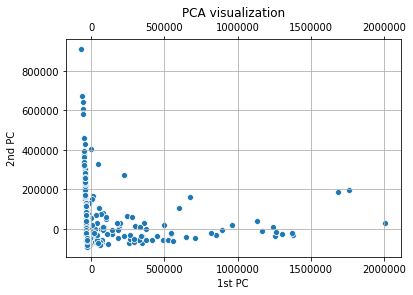

In [50]:
pca_visualize_2d(pats)

In [51]:
pca_visualize_3d(pats)

First 3 components explain 96.89% of the variance in the original data


[See plot here](https://plot.ly/~valentin.loftsson/8/#/)

**Log transformed and standardized patients data**

First 2 components explain 27.39% of the variance in the original data


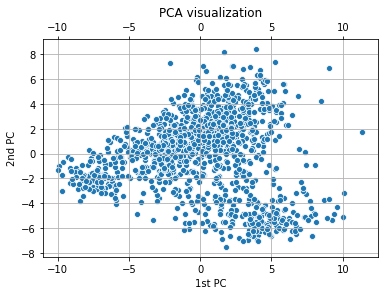

In [52]:
pca_visualize_2d(pats_log_stdized)

In [53]:
pca_visualize_3d(pats_log_stdized, filename="pats-log-stdized-pca-3d")

First 3 components explain 33.27% of the variance in the original data


[See plot here](https://plot.ly/~valentin.loftsson/69/#/)

**Heat map showing gene composition of principal components**

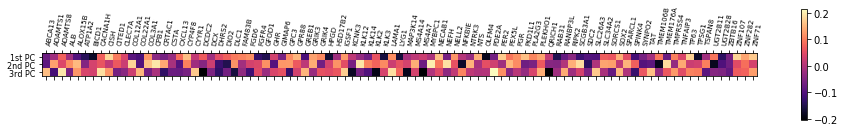

In [54]:
# PDX:  composition of first 3 principal components by gene
pca_gene_composition(X_pdx_stdized, "PCA_gene_decomposition_PDX", title="PCA gene composition PDX")

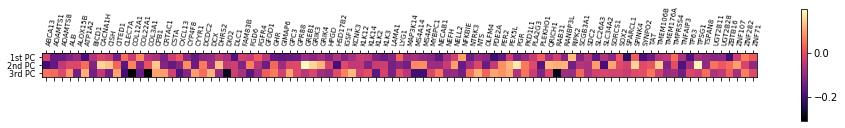

In [55]:
# TCGA: composition of first 3 principal components by gene
pca_gene_composition(pats_log_stdized, "PCA_gene_decomposition_TCGA", title="PCA gene composition TCGA")

The heatmaps clearly look very different, meaning that the first three principal components are different between the two data sets.